In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
from scipy.stats import norm

In [3]:
dat = pd.read_csv('WaffleDivorce.csv', sep=';')

In [4]:
age_std = (dat['MedianAgeMarriage']-dat['MedianAgeMarriage'].mean())/dat['MedianAgeMarriage'].std()
div_std = (dat['Divorce']-dat['Divorce'].mean())/dat['Divorce'].std()
mar_std = (dat['Marriage']-dat['Marriage'].mean())/dat['Marriage'].std()

## Remember that the DAG model is given by $A \rightarrow D \leftarrow M$ and $A \rightarrow M$

In [5]:
with pm.Model() as model_divorce:
    # A -> D <- M
    alpha    = pm.Normal('alpha', mu=0, sd=0.2)
    beta_M   = pm.Normal('beta_M', mu=0, sigma=0.5)
    beta_A   = pm.Normal('beta_A', mu=0, sigma=0.5)
    sigma    = pm.Exponential('sigma', lam=1)
    divorce  = pm.Normal('divorce', mu=alpha + beta_M * mar_std + beta_A * age_std, sd=sigma, observed=div_std)
    
    # A -> M
    alpha_M  = pm.Normal('alpha_M', mu=0, sd=0.2)
    beta_AM  = pm.Normal('beta_AM', mu=0, sigma=0.5)
    sigma_M  = pm.Exponential('sigma_M', lam=1)
    marriage = pm.Normal('marriage', mu=alpha_M + beta_AM * age_std, sd=sigma_M, observed=mar_std)
    
    par_post = pm.find_MAP()
    hessian  = pm.find_hessian(par_post, vars=[alpha, beta_M, beta_A, sigma, alpha_M, beta_AM, sigma_M])

In [6]:
par_post

{'alpha': array(1.54732302e-15),
 'beta_M': array(-0.06537934),
 'beta_A': array(-0.61351263),
 'sigma_log__': array(-0.24192215),
 'alpha_M': array(1.32997906e-15),
 'beta_AM': array(-0.69473788),
 'sigma_M_log__': array(-0.38311204),
 'sigma': array(0.7851173),
 'sigma_M': array(0.68173651)}

In [7]:
st_dev = np.diag(np.linalg.inv(hessian))**0.5

# A -> D <- M
sample_alpha  = norm.rvs(size=10**4, loc=par_post['alpha'],  scale=st_dev[0])
sample_beta_M = norm.rvs(size=10**4, loc=par_post['beta_M'], scale=st_dev[1])
sample_beta_A = norm.rvs(size=10**4, loc=par_post['beta_A'], scale=st_dev[2])
sample_sigma  = norm.rvs(size=10**4, loc=par_post['sigma'],  scale=st_dev[3])

# A -> D
sample_alpha_M = norm.rvs(size=10**4, loc=par_post['alpha_M'], scale=st_dev[4])
sample_beta_AM = norm.rvs(size=10**4, loc=par_post['beta_AM'], scale=st_dev[5])
sample_sigma_M = norm.rvs(size=10**4, loc=par_post['sigma_M'], scale=st_dev[6])

In [8]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(sample_alpha + sample_beta_M * mar_std[0] + sample_beta_A * age_std[0], [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [9]:
for i in range(1, len(mar_std)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(np.quantile(sample_alpha + sample_beta_M * mar_std[i] + sample_beta_A * age_std[i],
                         [0.025, 0.975]).reshape(1,2), columns=['LCI', 'UCI'])])

In [10]:
ConfidenceIntervals = ConfidenceIntervals.reset_index(drop=True)
ConfidenceIntervals['Obs_Divorce']  = div_std
ConfidenceIntervals['Pred_Divorce'] = par_post['alpha'] + par_post['beta_M'] * mar_std + par_post['beta_A'] * age_std
ConfidenceIntervals['Loc'] = dat['Loc']

## Posterior prediction plot

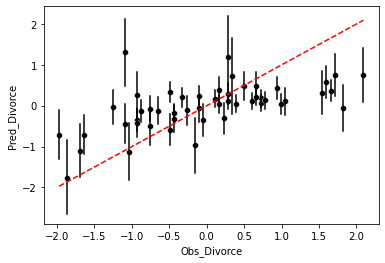

In [11]:
sns.scatterplot(data=ConfidenceIntervals, x='Obs_Divorce', y='Pred_Divorce', color='k')

for i in range(50):
    plt.plot([ConfidenceIntervals['Obs_Divorce'][i], ConfidenceIntervals['Obs_Divorce'][i]],
             [ConfidenceIntervals['LCI'][i], ConfidenceIntervals['UCI'][i]], color='k')
    
plt.plot([ConfidenceIntervals['Obs_Divorce'].min(), ConfidenceIntervals['Obs_Divorce'].max()],
         [ConfidenceIntervals['Obs_Divorce'].min(), ConfidenceIntervals['Obs_Divorce'].max()],
         color='r', linestyle='--')

plt.savefig('prediction_plot.png', transparent=True)

## Counterfactual plots

### Manipulating A

In [12]:
sample_A = np.linspace(-2, 2, 30)

In [13]:
sample_M = norm.rvs(loc=sample_alpha_M + sample_beta_AM * sample_A[0], scale=sample_sigma_M)
sample_D = norm.rvs(loc=sample_alpha + sample_beta_M * sample_M + sample_beta_A * sample_A[0], scale=sample_sigma)

PredictionIntervals_Marriage = pd.DataFrame(
    np.append(np.quantile(sample_M, [0.025, 0.975]), sample_M.mean()).reshape(1,3),
              columns=['LPI', 'UPI', 'Counterfactual_M'])

PredictionIntervals_Divorce = pd.DataFrame(
    np.append(np.quantile(sample_D, [0.025, 0.975]), sample_D.mean()).reshape(1,3),
              columns=['LPI', 'UPI', 'Counterfactual_D'])

In [14]:
for i in range(1, len(sample_A)):
    
    sample_M = norm.rvs(loc=sample_alpha_M + sample_beta_AM * sample_A[i], scale=sample_sigma_M)
    sample_D = norm.rvs(loc=sample_alpha + sample_beta_M * sample_M + sample_beta_A * sample_A[i], scale=sample_sigma)
    
    PredictionIntervals_Marriage = pd.concat(
        [PredictionIntervals_Marriage,
         pd.DataFrame(
             np.append(np.quantile(sample_M, [0.025, 0.975]), sample_M.mean()).reshape(1,3),
             columns=['LPI', 'UPI', 'Counterfactual_M'])
        ])
        
    PredictionIntervals_Divorce = pd.concat(
        [PredictionIntervals_Divorce,
         pd.DataFrame(
             np.append(np.quantile(sample_D, [0.025, 0.975]), sample_D.mean()).reshape(1,3),
             columns=['LPI', 'UPI', 'Counterfactual_D'])
        ])

In [15]:
PredictionIntervals_Marriage = PredictionIntervals_Marriage.reset_index(drop=True)
PredictionIntervals_Marriage['Manipulated_A'] = sample_A

PredictionIntervals_Divorce = PredictionIntervals_Divorce.reset_index(drop=True)
PredictionIntervals_Divorce['Manipulated_A'] = sample_A

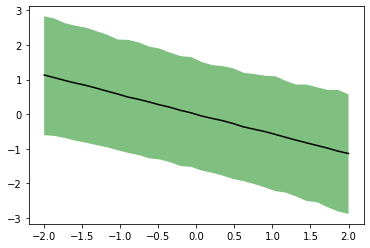

In [16]:
plt.plot(PredictionIntervals_Divorce['Manipulated_A'], PredictionIntervals_Divorce['Counterfactual_D'], color='k')

plt.fill_between(PredictionIntervals_Divorce['Manipulated_A'],
                 PredictionIntervals_Divorce['LPI'],
                 PredictionIntervals_Divorce['UPI'],
                 facecolor='green', alpha=0.5)

plt.savefig('count_D_mani_A.png', transparent=True)

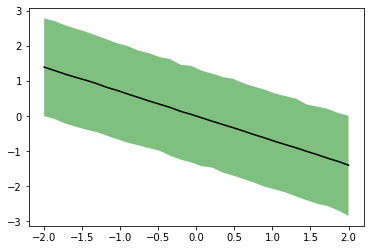

In [17]:
plt.plot(PredictionIntervals_Marriage['Manipulated_A'], PredictionIntervals_Marriage['Counterfactual_M'], color='k')

plt.fill_between(PredictionIntervals_Marriage['Manipulated_A'],
                 PredictionIntervals_Marriage['LPI'],
                 PredictionIntervals_Marriage['UPI'],
                 facecolor='green', alpha=0.5)

plt.savefig('count_M_mani_A.png', transparent=True)

### Manipulating M

In [18]:
sample_M = np.linspace(-2, 2, 30)
fix_A    = 0

In [19]:
sample_D = norm.rvs(loc=sample_alpha + sample_beta_M * sample_M[0] + sample_beta_A * fix_A, scale=sample_sigma)

PredictionIntervals_Divorce = pd.DataFrame(
    np.append(np.quantile(sample_D, [0.025, 0.975]), sample_D.mean()).reshape(1,3),
              columns=['LPI', 'UPI', 'Counterfactual_D'])

In [20]:
for i in range(1, len(sample_A)):
    
    sample_D = norm.rvs(loc=sample_alpha + sample_beta_M * sample_M[i] + sample_beta_A * fix_A, scale=sample_sigma)
        
    PredictionIntervals_Divorce = pd.concat(
        [PredictionIntervals_Divorce,
         pd.DataFrame(
             np.append(np.quantile(sample_D, [0.025, 0.975]), sample_D.mean()).reshape(1,3),
             columns=['LPI', 'UPI', 'Counterfactual_D'])
        ])

In [21]:
PredictionIntervals_Divorce = PredictionIntervals_Divorce.reset_index(drop=True)
PredictionIntervals_Divorce['Manipulated_M'] = sample_M

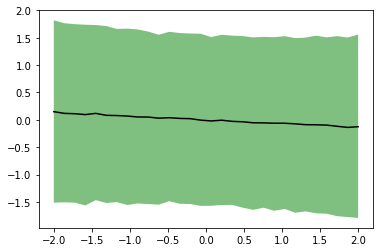

In [22]:
plt.plot(PredictionIntervals_Divorce['Manipulated_M'], PredictionIntervals_Divorce['Counterfactual_D'], color='k')

plt.fill_between(PredictionIntervals_Divorce['Manipulated_M'],
                 PredictionIntervals_Divorce['LPI'],
                 PredictionIntervals_Divorce['UPI'],
                 facecolor='green', alpha=0.5)

plt.savefig('count_D_mani_M.png', transparent=True)